In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
import ssm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from scipy import stats

from notebooks.imports import *
from config import dir_config, main_config
from src.utils.glm_hmm_utils import *
from src.utils import pmf_utils
import pickle
import copy

### Configuration

In [17]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"))
data = pd.read_csv(Path(processed_dir, "processed_data_accu_60_all.csv"))

metadata['session_id'] = metadata[['subject_id', 'treatment']].apply(lambda x: '_'.join(x.astype(str).str.upper()), axis=1)
data['session_id'] = data[['subject_id', 'medication']].apply(lambda x: '_'.join(x.astype(str).str.upper()), axis=1)

experiment_sites = ["Stanford"]
metadata = metadata[metadata['experiment_site'].isin(experiment_sites)].reset_index(drop=True)
data = data[data['subject_id'].isin(metadata['subject_id'])].reset_index(drop=True)

with open(Path(processed_dir, f'glm_hmm_final.pkl'), 'rb') as f:
    glm_hmm_results = pickle.load(f)
models_session_wise = glm_hmm['session_wise']["models"]

# Condition-wise plot

In [19]:
subjects = metadata['subject_id'].unique()
session_ids = np.array(glm_hmm["session_wise"]['session_ids'])

rows = []

for session_id in session_ids:
	subject = session_id.split('_')[0]
	medication = session_id.split('_')[1]

	model = models_session_wise[session_id]
	params = -np.array(model.observations.params).reshape(model.K, -1)
	row = {
		'subject_id': subject,
		'medication': medication,
		'state_1_stimulus': params[0, 0],
		'state_1_color': params[0, 1],
		'state_1_bias': params[0, 2],
		'state_2_stimulus': params[1, 0],
		'state_2_color': params[1, 1],
		'state_2_bias': params[1, 2],
	}

	# Dynamically add extra features based on model.M
	if model.M > 3:
		row["state_1_prev_choice"] = params[0, 3]
		row["state_2_prev_choice"] = params[1, 3]
	if model.M > 4:
		row["state_1_prev_target"] = params[0, 4]
		row["state_2_prev_target"] = params[1, 4]
	if model.M > 5:
		row["state_1_prev_color"] = params[0, 5]
		row["state_2_prev_color"] = params[1, 5]

	# Append row to list
	rows.append(row)


pd_glm_hmm = pd.DataFrame(rows)

In [20]:
trem_subjects = metadata.loc[metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
brady_subjects = metadata.loc[metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()

Wilcoxon signed-rank test for state_1_stimulus: statistic=16.000, p-value=0.84375
Wilcoxon signed-rank test for state_1_color: statistic=14.000, p-value=0.64062
Wilcoxon signed-rank test for state_1_bias: statistic=12.000, p-value=0.46094
Wilcoxon signed-rank test for state_1_prev_choice: statistic=15.000, p-value=0.74219
Wilcoxon signed-rank test for state_1_prev_target: statistic=15.000, p-value=0.74219
Wilcoxon signed-rank test for state_2_stimulus: statistic=4.000, p-value=0.05469
Wilcoxon signed-rank test for state_2_color: statistic=9.000, p-value=0.25000
Wilcoxon signed-rank test for state_2_bias: statistic=16.000, p-value=0.84375
Wilcoxon signed-rank test for state_2_prev_choice: statistic=17.000, p-value=0.94531
Wilcoxon signed-rank test for state_2_prev_target: statistic=6.000, p-value=0.10938


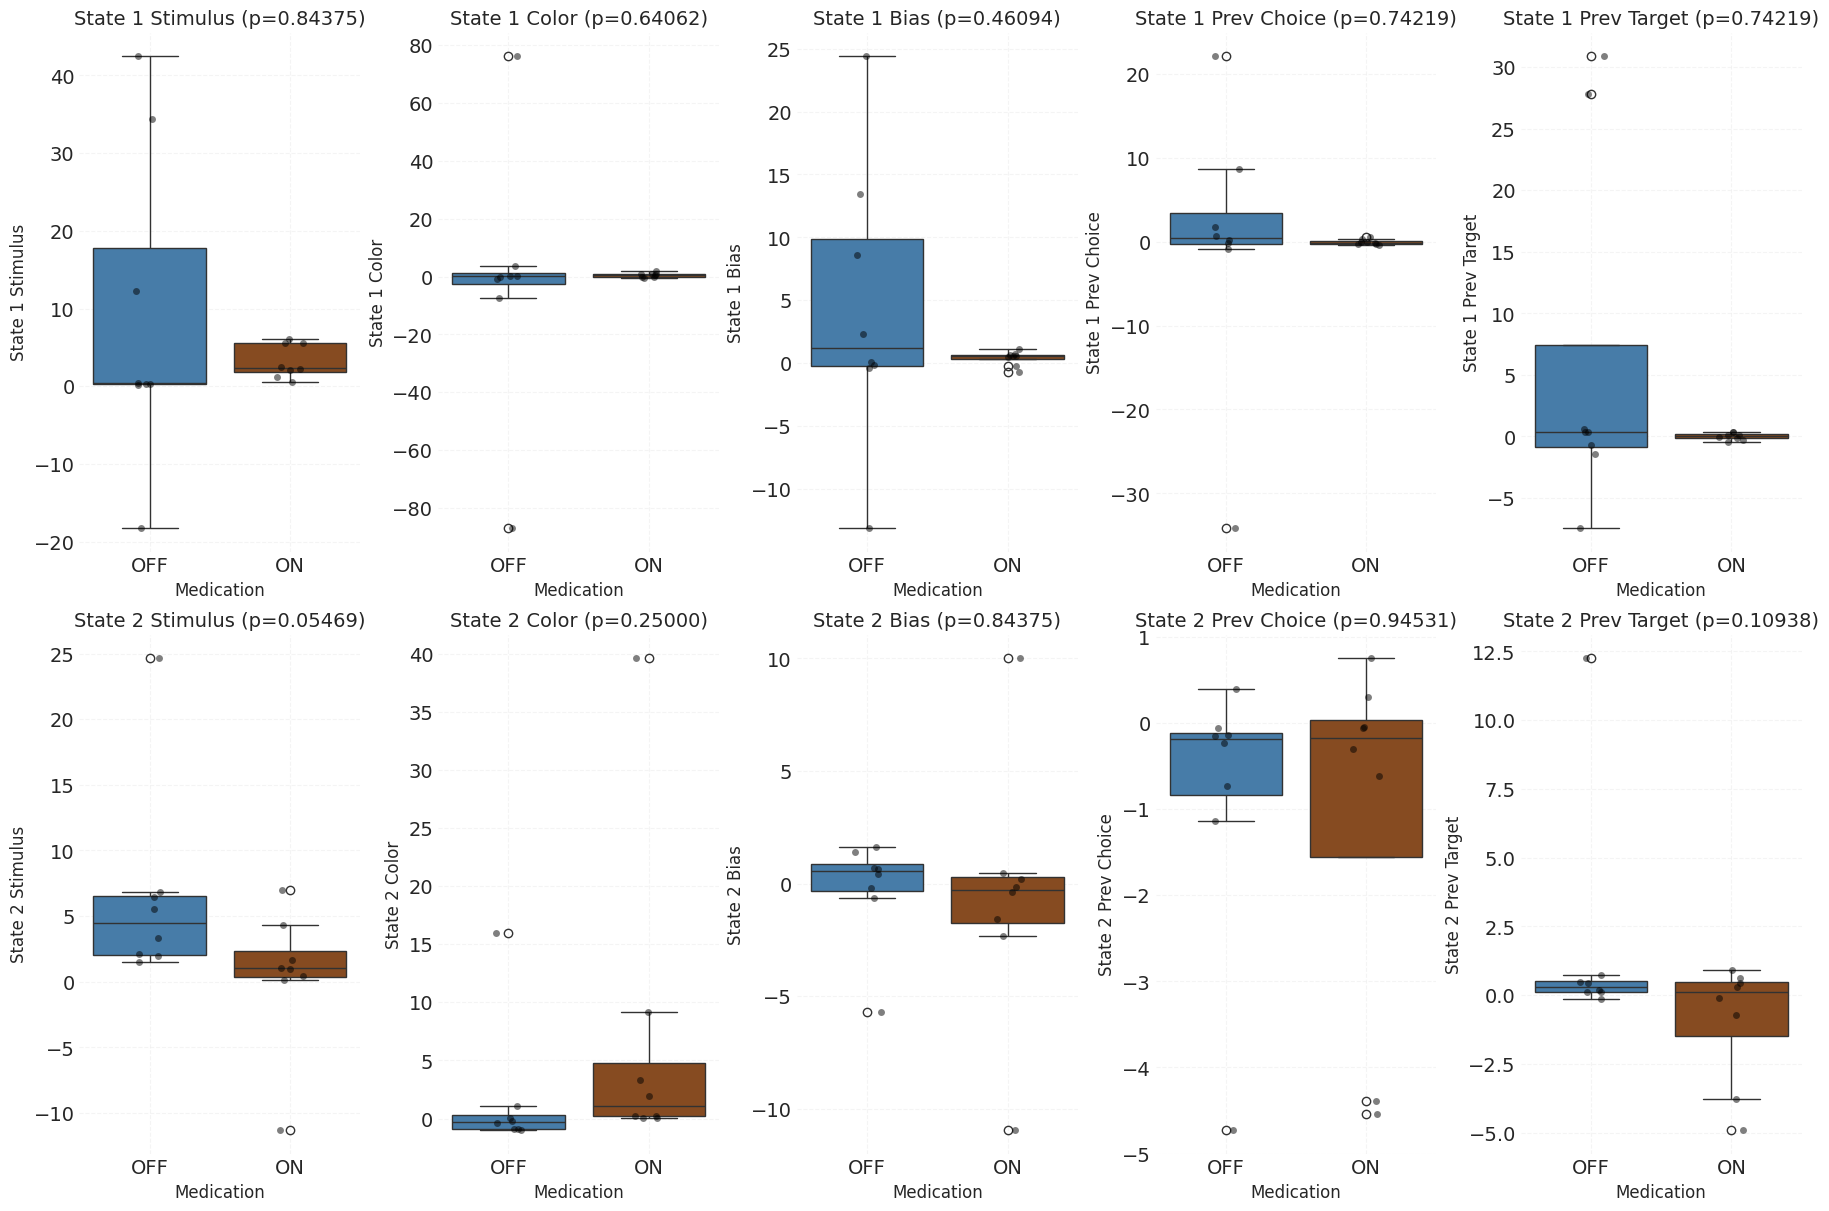

In [23]:
subject_group = trem_subjects
df = pd_glm_hmm.copy()
df = df[df['subject_id'].isin(subject_group)].reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Prepare figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 5, figsize=(18, 12))

# Features for both states
features = [
	["state_1_stimulus", "state_1_color", "state_1_bias", "state_1_prev_choice", "state_1_prev_target"],
	["state_2_stimulus", "state_2_color", "state_2_bias", "state_2_prev_choice", "state_2_prev_target"],
]
titles = [
	["State 1 Stimulus", "State 1 Color", "State 1 Bias", "State 1 Prev Choice", "State 1 Prev Target"],
	["State 2 Stimulus", "State 2 Color", "State 2 Bias", "State 2 Prev Choice", "State 2 Prev Target"],
]
colors = ["#377eb8", "#974810"]  # OFF (blue), ON (brown)

for row in range(2):  # Iterate over states (state 1 and state 2)
	for col in range(5):  # Iterate over stimulus, color, bias
		feature = features[row][col]
		ax = axes[row, col]

		# Filter ON and OFF data
		on_data = df[df["medication"] == "ON"][feature]
		off_data = df[df["medication"] == "OFF"][feature]

		# Ensure equal pairing
		common_subjects = set(df[df["medication"] == "ON"]["subject_id"]) & set(
			df[df["medication"] == "OFF"]["subject_id"]
		)
		on_data = df[(df["medication"] == "ON") & (df["subject_id"].isin(common_subjects))][feature]
		off_data = df[(df["medication"] == "OFF") & (df["subject_id"].isin(common_subjects))][feature]

		stat, p_value = wilcoxon(off_data, on_data)
		test_name = "Wilcoxon signed-rank test"

		# # Normality check
		# _, p_on = shapiro(on_data)
		# _, p_off = shapiro(off_data)
		# # Choose appropriate test
		# if p_on > 0.05 and p_off > 0.05:
		#     stat, p_value = ttest_rel(off_data, on_data)
		#     test_name = "Paired t-test"
		# else:
		#     stat, p_value = wilcoxon(off_data, on_data)
		#     test_name = "Wilcoxon signed-rank test"

		# Print test results
		print(f"{test_name} for {feature}: statistic={stat:.3f}, p-value={p_value:.5f}")

		# Plot boxplot and stripplot
		sns.boxplot(x="medication", y=feature, data=df, palette=colors, ax=ax)
		sns.stripplot(x="medication", y=feature, data=df, color="black", alpha=0.5, jitter=True, ax=ax)

		# Formatting
		ax.set_title(f"{titles[row][col]} (p={p_value:.5f})", fontsize=14)
		ax.set_xlabel("Medication", fontsize=12)
		ax.set_ylabel(titles[row][col], fontsize=12)
		ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout and show
plt.tight_layout()
plt.show()

Wilcoxon signed-rank test for state_1_stimulus: statistic=1.000, p-value=0.03125
Wilcoxon signed-rank test for state_1_color: statistic=9.000, p-value=0.46875
Wilcoxon signed-rank test for state_1_bias: statistic=9.000, p-value=0.46875
Wilcoxon signed-rank test for state_1_prev_choice: statistic=12.000, p-value=0.81250
Wilcoxon signed-rank test for state_1_prev_target: statistic=1.000, p-value=0.03125
Wilcoxon signed-rank test for state_2_stimulus: statistic=6.000, p-value=0.21875
Wilcoxon signed-rank test for state_2_color: statistic=13.000, p-value=0.93750
Wilcoxon signed-rank test for state_2_bias: statistic=12.000, p-value=0.81250
Wilcoxon signed-rank test for state_2_prev_choice: statistic=9.000, p-value=0.46875
Wilcoxon signed-rank test for state_2_prev_target: statistic=5.000, p-value=0.15625


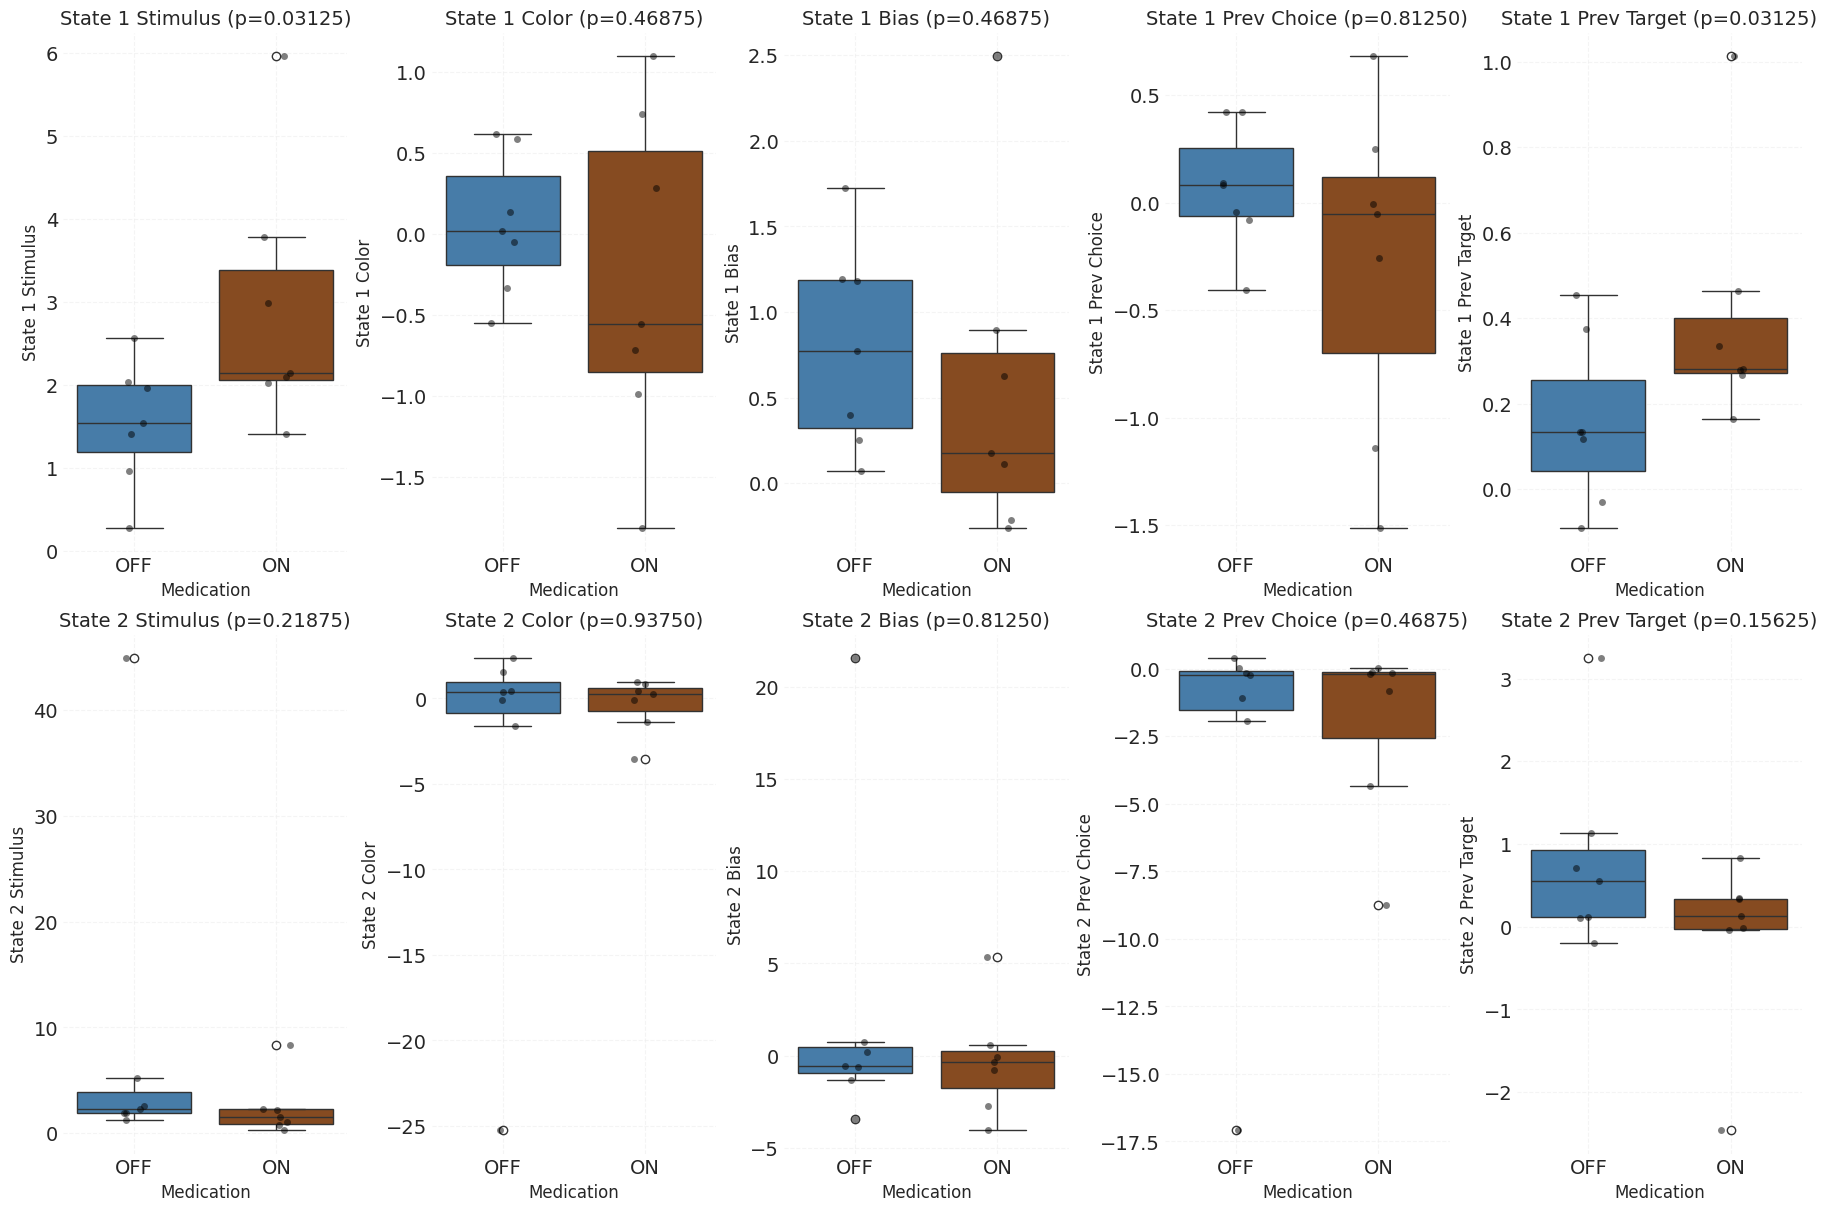

In [22]:
subject_group = brady_subjects
df = pd_glm_hmm.copy()
df = df[df['subject_id'].isin(subject_group)].reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Prepare figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 5, figsize=(18, 12))

# Features for both states
features = [
	["state_1_stimulus", "state_1_color", "state_1_bias", "state_1_prev_choice", "state_1_prev_target"],
	["state_2_stimulus", "state_2_color", "state_2_bias", "state_2_prev_choice", "state_2_prev_target"],
]
titles = [
	["State 1 Stimulus", "State 1 Color", "State 1 Bias", "State 1 Prev Choice", "State 1 Prev Target"],
	["State 2 Stimulus", "State 2 Color", "State 2 Bias", "State 2 Prev Choice", "State 2 Prev Target"],
]
colors = ["#377eb8", "#974810"]  # OFF (blue), ON (brown)

for row in range(2):  # Iterate over states (state 1 and state 2)
	for col in range(5):  # Iterate over stimulus, color, bias
		feature = features[row][col]
		ax = axes[row, col]

		# Filter ON and OFF data
		on_data = df[df["medication"] == "ON"][feature]
		off_data = df[df["medication"] == "OFF"][feature]

		# Ensure equal pairing
		common_subjects = set(df[df["medication"] == "ON"]["subject_id"]) & set(
			df[df["medication"] == "OFF"]["subject_id"]
		)
		on_data = df[(df["medication"] == "ON") & (df["subject_id"].isin(common_subjects))][feature]
		off_data = df[(df["medication"] == "OFF") & (df["subject_id"].isin(common_subjects))][feature]

		stat, p_value = wilcoxon(off_data, on_data)
		test_name = "Wilcoxon signed-rank test"

		# # Normality check
		# _, p_on = shapiro(on_data)
		# _, p_off = shapiro(off_data)
		# # Choose appropriate test
		# if p_on > 0.05 and p_off > 0.05:
		#     stat, p_value = ttest_rel(off_data, on_data)
		#     test_name = "Paired t-test"
		# else:
		#     stat, p_value = wilcoxon(off_data, on_data)
		#     test_name = "Wilcoxon signed-rank test"

		# Print test results
		print(f"{test_name} for {feature}: statistic={stat:.3f}, p-value={p_value:.5f}")

		# Plot boxplot and stripplot
		sns.boxplot(x="medication", y=feature, data=df, palette=colors, ax=ax)
		sns.stripplot(x="medication", y=feature, data=df, color="black", alpha=0.5, jitter=True, ax=ax)

		# Formatting
		ax.set_title(f"{titles[row][col]} (p={p_value:.5f})", fontsize=14)
		ax.set_xlabel("Medication", fontsize=12)
		ax.set_ylabel(titles[row][col], fontsize=12)
		ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout and show
plt.tight_layout()
plt.show()